Let's steal some pre-trained coefficients from one of the best, recent pubs so far: OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose).

You need the binary distribution of Caffe (http://caffe.berkeleyvision.org/installation.html) if you would like to take out the original pre-trained weights.

In [11]:
CAFFE_PYTHON_PATH='D:\Research\libs\CaffeBinaryDistro3.5/python'


from __future__ import division, print_function
import sys
sys.path.append(CAFFE_PYTHON_PATH) 
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
from keras.layers import *
from keras.models import *
import caffe
from time import clock
import numpy as np
import os
from IPython.display import clear_output

In [12]:
layers_output = './layers'
caffe_model = './pose_iter_102000.caffemodel'
caffe_proto = './pose_deploy.prototxt'
KERAS_WEIGHTS_FILE = "./model_weights.h5"
KERAS_MODEL_FILE = "./model.h5"
TEST_IMAGE_PATH = './test_image.png'

Code used for exporting caffe's layers and converting them to numpy files was taken from here: https://github.com/michalfaber/keras_Realtime_Multi-Person_Pose_Estimation

In [ ]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_proto, caffe_model, caffe.TEST)

# layer names and output shapes
#net.blobs.
for layer_name, blob in net.blobs.items():
    print(layer_name, blob.data.shape)

# write out weight matrices and bias vectors
for k, v in net.params.items():
    print(k, v[0].data.shape, v[1].data.shape)
    np.save(os.path.join(layers_output, "W_{:s}.npy".format(k)), v[0].data)
    np.save(os.path.join(layers_output, "b_{:s}.npy".format(k)), v[1].data)

print("Done !")

# Model definition

In [3]:
input_ = Input((None, None, 3), name='image')

def main_block(input_, padding='same'):
    x = Conv2D(64, (3,3), strides=(1,1), padding=padding, name='conv1_1', activation='relu')(input_)
    x = Conv2D(64, (3,3), strides=(1,1), padding=padding, name='conv1_2', activation='relu')(x)
    x = MaxPool2D((2,2), strides=(2,2), name='pool1_stage1')(x)

    x = Conv2D(128, (3,3), strides=(1,1), padding=padding, name='conv2_1', activation='relu')(x)
    x = Conv2D(128, (3,3), strides=(1,1), padding=padding, name='conv2_2', activation='relu')(x)
    x = MaxPool2D((2,2), strides=(2,2), name='pool2_stage1')(x)

    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_1', activation='relu')(x)
    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_2', activation='relu')(x)
    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_3', activation='relu')(x)
    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_4', activation='relu')(x)
    x = MaxPool2D((2,2), strides=(2,2), name='pool3_stage1')(x)

    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_1', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_2', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_3', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_4', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv5_1', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv5_2', activation='relu')(x)
    conv5_3_CPM = Conv2D(128, (3,3), strides=(1,1), padding=padding, name='conv5_3_CPM', activation='relu')(x)
    x = Conv2D(512, (1,1), strides=(1,1), padding='valid', name='conv6_1_CPM', activation='relu')(conv5_3_CPM)
    conv6_2_CPM = Conv2D(22, (1,1), padding='valid', strides=(1,1), name='conv6_2_CPM')(x)
    return conv5_3_CPM, conv6_2_CPM

conv5_3_CPM, conv6_2_CPM = main_block(input_)

def stage_block(conv5_3_CPM, prev_stage, stage, padding='same'):
    x = concatenate([ prev_stage, conv5_3_CPM ], axis=3, name='concat_stage{}'.format(stage))
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv1_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv2_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv3_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv4_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv5_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (1,1), strides=(1,1), padding='valid', name='Mconv6_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(22, (1,1), strides=(1,1), padding='valid', name='Mconv7_stage{}'.format(stage))(x)
    return x
    
prev_stage = conv6_2_CPM
for stage in range(2, 7):
    prev_stage = stage_block(conv5_3_CPM, prev_stage, stage)
    
x = prev_stage
model = Model(input_, x)



In [8]:
# Loading from files and saving to the model internally, then using "save_weights" to store into h5
for layer in model.layers:
    layer_name = layer.name
    if (os.path.exists(os.path.join(layers_output, "W_%s.npy" % layer_name))):
        print('Loading {}'.format(layer_name))
        w = np.array(np.load(os.path.join(layers_output, "W_%s.npy" % layer_name)).tolist())
        b = np.array(np.load(os.path.join(layers_output, "b_%s.npy" % layer_name)).tolist())

        w = np.transpose(w, (2, 3, 1, 0))

        layer_weights = [w, b]
        layer.set_weights(layer_weights)

model.save_weights(KERAS_MODEL_FILE)       # SAVE WEIGHTS FILE
model.save(KERAS_MODEL_FILE)               # SAVE MODEL FILE

print("Done !")

Done !


In [9]:
# Or loading from prepared weigths file

model.load_weights(KERAS_WEIGHTS_FILE)
print('LOADED!')

LOADED!


Code for this fragment was taken from https://github.com/michalfaber/keras_Realtime_Multi-Person_Pose_Estimation and modified. Prety useful peak detection / non-maxima suppression

In [13]:
def find_peaks(heatmap_avg, thre=0.1, sigma=3):
    all_peaks = []
    peak_counter = 0

    for part in range(0, heatmap_avg.shape[-1]):
        map_ori = heatmap_avg[:,:,part]
        map = gaussian_filter(map_ori, sigma=sigma)
#        plt.imshow(map)
#        plt.show()

        map_left = np.zeros(map.shape)
        map_left[1:,:] = map[:-1,:]
        map_right = np.zeros(map.shape)
        map_right[:-1,:] = map[1:,:]
        map_up = np.zeros(map.shape)
        map_up[:,1:] = map[:,:-1]
        map_down = np.zeros(map.shape)
        map_down[:,:-1] = map[:,1:]

        peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > thre))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
        peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
        id = range(peak_counter, peak_counter + len(peaks))
        peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks, peak_counter




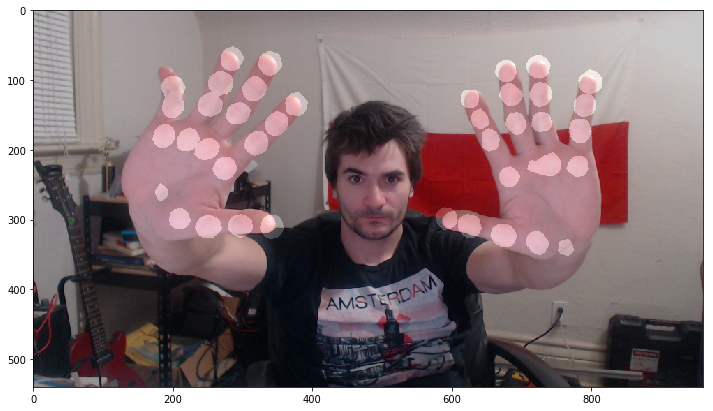

In [14]:
def process_image(model, image_orig, scale_mul=2, peaks_th=0.1, sigma=3, mode='heatmap'):
    
    scale = 368/image_orig.shape[1]
    scale = scale*scale_mul
    image =  cv2.resize(image_orig, (0,0), fx=scale, fy=scale) 

    start = clock()
    net_out = model.predict(np.expand_dims( image /256 -0.5 ,0))
    stop = clock()
    took = stop-start
    
    out = cv2.resize( net_out[0], (image_orig.shape[1], image_orig.shape[0]) )
    image_out = image_orig
    
    mask = np.zeros_like(image_out).astype(np.float32)
    if mode == 'heatmap':
        for chn in range(0, out.shape[-1]-2):
            m = np.repeat(out[:,:,chn:chn+1],3, axis=2)
            m = 255*( np.abs(m)>0.2)
            
            mask = mask + m*(mask==0)
        mask = np.clip(mask, 0, 255)
        image_out = image_out*0.8 + mask*0.2
    else:
        peaksR = find_peaks(out, peaks_th, sigma=sigma)[0]
        peaksL = find_peaks(-out, peaks_th, sigma=sigma)[0]

        print(peaksR)
        for peak in peaksR:
            if(len(peak)):
                peak = peak[0]
                cv2.drawMarker(image_out, (peak[0], peak[1]), (0,255,0), cv2.MARKER_STAR )
                
    image_out = np.clip(image_out, 0, 255).astype(np.uint8)
                
    return image_out, took

image = cv2.cvtColor(cv2.imread(TEST_IMAGE_PATH), cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (960, 540))
image_out = process_image(model, image)[0]
plt.figure(figsize=(12,12))
plt.imshow(image_out)
plt.show()

In [ ]:
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX

while 1:
    ret, image = cap.read()
    clear_output()

    image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    start = clock()
    image_out, inference_took = process_image(model, image)
    stop = clock()
    took = stop-start
    cv2.putText(image_out,'Inference: {}s, post: {}s'.format(  np.round(inference_took,3) , np.round(took-inference_took,3) ),(10,30), font, 1,(255,255,255),2,cv2.LINE_AA)

#    cv2.imshow("OpenPose's stolen hand tracking network in Keras", cv2.cvtColor(image_out, cv2.COLOR_RGB2BGR))
    cv2.imshow("OpenPose's stolen hand tracking network in Keras", image_out)
    cv2.waitKey(1)

cap.release()